# 3D_BclinNRJ_CompPlot
compute 3D baroclinic energy (high-pass of BP filtered) in a subdomain, take average or snapshot (of lowpass-filtered energy), store it in a netCDF file and plot the vertical integral.


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'serif'
from mpl_toolkits.basemap import Basemap

import numpy as np
from netCDF4 import Dataset
import time, sys, os
from datetime import datetime
import scipy.signal as sig
import gsw
for pap in ["/home/lahaye/Coding/"+pa for pa in ["Python_ROMS_Modules/lahaye"]]:
    if pap not in sys.path: sys.path.append(pap)
import comp_zlevs as zlev

KRYPTON = "/data0/project/vortex/lahaye/"
RUCHBA = "/net/ruchba/local/tmp/2/lahaye/"

In [3]:
simul = "luckyt"
it = None

xm, ym = -32.28, 37.3
Lx, Ly = 2*2*30*1852*np.array([1,1]) # extend in m
fcut_hf = 1./30
fcut_lf = 0.75 * fcut_hf

# plotting parameters
fs       = 12
proj     = 'lcc'
res      = 'i'
stride   = 1
zlevs = [0,1000,2000,3500]
topocol = 'k'     # isobath. contour color
grdcol = 'gray'   # grid color
rlevs = [10, 20, 30] # nautical miles, radius around center to show

path_2D = KRYPTON + "{0}_tseries/{0}_tseries_2Dvars.nc".format(simul)
path_3D = path_2D.replace('2Dvars','{0}_iz{1:02d}') # var,iz
path_grd = KRYPTON + "lucky_corgrd.nc"

rho0 = 1025.

jjs, iis: 411 559 439 587 from parent: X 2
loaded grid
min/max lon, lat: -33.5439 -31.018 36.294 38.2857


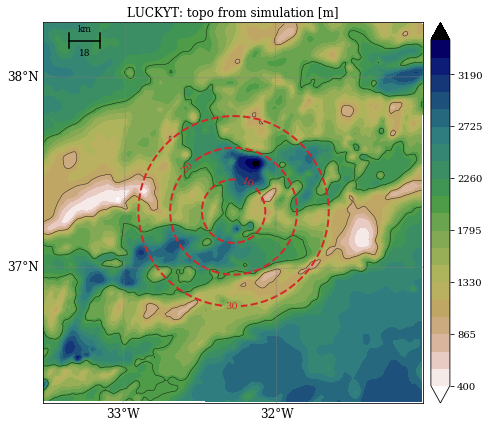

In [9]:
# Load data: grid & topo
doploth = True  # plot topo 

# first some meta-data from 2D file
nc = Dataset(path_2D, "r")
ncvar = nc.variables
xi = ncvar['xi_rho'][:].astype(int)
eta = ncvar['eta_rho'][:].astype(int)
hc, Cs_r, Cs_w = nc.hc, nc.Cs_r, nc.Cs_w
lon = ncvar['lon_rho'][:]
lat = ncvar['lat_rho'][:]
times = nc.variables['scrum_time'][:]
if nc.variables['scrum_time'].units == "s": times /= 3600
nc.close()
Ny, Nx = lon.shape
Nt = len(times)
st = np.diff(xi)[0]
if np.diff(eta)[0] != st: raise ValueError("spatial subsamb step does not match")
dt = np.diff(times)[0]

# load grid
ncg = Dataset(path_grd,'r')
dx = .5*(np.mean(1./ncg.variables['pm'][eta,:][:,xi]) + np.mean(1./ncg.variables['pn'][eta,:][:,xi]) ) * st
jm, im = np.unravel_index( ((lon-xm)**2 + (lat-ym)**2).argmin(), (Ny,Nx) )
j1, j2 = jm + np.array([-1,1])*int(Lx/dx/2.)
i1, i2 = im + np.array([-1,1])*int(Ly/dx/2.)
print("jjs, iis:",j1,j2,i1,i2, "from parent: X",st)
eta, xi = eta[j1:j2], xi[i1:i2]
topo = ncg.variables['h'][eta,:][:,xi]
lon = lon[j1:j2,i1:i2]
lat = lat[j1:j2,i1:i2]
print("loaded grid")
lonm, latm = lon.mean(axis=0), lat.mean(axis=1)
ny, nx = lon.shape
Nz = Cs_r.size

rad = gsw.distance(np.c_[lon.ravel(),np.ones(nx*ny)*xm],np.c_[lat.ravel(),np.ones(nx*ny)*ym]).reshape(ny,nx)/1e3 # [km]

print("min/max lon, lat:", lon.min(), lon.max(), lat.min(), lat.max())
# plot it
if doploth:
    vmin, vmax = round(topo.min()+50,-2), round(topo.max()-50,-2)
    levs = np.linspace(vmin, vmax, 21)
    fig = plt.figure(figsize=(8,7))
    ax = plt.gca()
    bm = Basemap(projection=proj,resolution=res,lon_0=lon.mean(),\
            lat_0=lat.mean(),width=Lx,height=Ly)
    xx, yy = bm(lon, lat)
    bm.drawcoastlines(color='gray')
    bm.fillcontinents(color='gray')
    bm.drawparallels(np.arange(-60,70,stride),labels=[1,0,0,0],linewidth=0.8,\
                    fontsize=fs,color=grdcol)
    bm.drawmeridians(np.arange(-100,100,stride),labels=[0,0,0,1],linewidth=0.8,\
                    fontsize=fs,color=grdcol)
    hct = bm.contourf(xx, yy, topo, levels=levs, cmap="gist_earth_r", extend="both")
    hcb = bm.colorbar(hct)
    for item in hct.collections:
        item.set_rasterized(True)
    hct = bm.contour(xx, yy, topo, levels=zlevs, colors=topocol, linewidths=0.5, alpha=0.8)
    for item in hct.collections:
        item.set_rasterized(True)

    bm.drawmapscale(xm - .8*(lonm.max()-lonm.min())/2, ym + .9*(latm.max()-latm.min())/2, xm, ym \
                    , length=18.5, units="km")
    hct = bm.contour(xx, yy, rad, levels=np.array(rlevs)*1.852, colors="tab:red", linestyles="--", linewidths=2)
    cls = ax.clabel(hct, fmt = "%.0f")
    for ii,cl in enumerate(cls):
        cl.set_text(str(round(rlevs[ii])))
        
    plt.title(simul.upper()+": topo from simulation [m]")

In [11]:
# load 2D vars and compute bclin NRJ
#nc = Dataset(path_2D, "r")
#ubar = nc.variables['ubar'][j1:j2,:,:][:,i1:i2,:]
#vbar = nc.variables["vbar"][j1:j2,:,:][:,i1:i2,:]
#times = nc.variables['scrum_time'][:]
#nc.close()

# N.B.: this version does not handle nans

bb, aa = sig.butter(4, 2*fcut_hf*dt, btype="high")
bl, al = sig.butter(4, 2*fcut_lf*dt, btype="low")

ebcl = np.zeros((Nz,ny,nx))
print("computing bclin KE: iz =", end=" ")
for iz in range(Nz):
    nc = Dataset(path_3D.format("u",iz), "r")
    uu = nc.variables['u'][0,j1:j2,:,:][:,i1:i2,:]
    nc.close()
    uu = sig.filtfilt(bb, aa, sig.detrend(uu, axis=-1), method="gust", axis=-1)
    if it is None or isinstance(it,"str"):
        uu = sig.filtfilt(bl, al, uu**2, method="gust", axis=-1).mean(axis=-1)
    else:
        uu = sig.filtfilt(bl, al, uu**2, method="gust", axis=-1)[:,:,it]
    nc = Dataset(path_3D.format("v",iz), "r")
    vv = nc.variables['v'][0,j1:j2,:,:][:,i1:i2,:]
    nc.close()
    vv = sig.filtfilt(bb, aa, sig.detrend(uu, axis=-1), method="gust", axis=-1)
    if it is None or isinstance(it,"str"):
        vv = sig.filtfilt(bl, al, vv**2, method="gust", axis=-1).mean(axis=-1)
    else:
        vv = sig.filtfilt(bl, al, vv**2, method="gust", axis=-1)[:,:,it]
    ebcl[iz,:,:] = .5 * rho0 * (uu + vv)
    print(iz, end=", ")

computing bclin KE: iz = 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 

In [12]:
# store in netCDF file
if it is None or isinstance(it,str):
    itn = "avg"
else:
    itn = "it{}".format(it)
filname = "{0}_ebl3D_j{1:03d}_i{2:03d}_{3}.nc".format(simul,jm,im,itn)

ncw = Dataset(filname, "w")
for dim,siz in zip(['s_rho','eta','xi'],[Nz,ny,nx]):
    ncw.createDimension(dim, siz)
for dim in ['eta','xi']:
    ncw.createVariable(dim,'i',(dim,))[:] = eval(dim)
    ncw.variables[dim].expl = "grid coord in parent domain (simulation)"
ncw.date_generated = datetime.today().isoformat()
ncw.simul = simul
ncw.from_ncfiles = path_2D
for var in ['lon','lat']:
    ncw.createVariable(var,'f',('eta','xi'))[:] = eval(var)
ncwar = ncw.createVariable('ebcl', 'f', ('s_rho','eta','xi'))
ncwar[:] = ebcl
ncwar.units = "J/m^3"
ncw.longname = "kinetic energy high-frequency signal"
ncw.freq_HPfilt = fcut_hf
ncw.freq_LPfilt = fcut_lf
ncw.frq_units = "h^{-1}"
ncw.hc = hc
ncw.Cs_r = Cs_r
ncw.Cs_w = Cs_w
ncw.close()

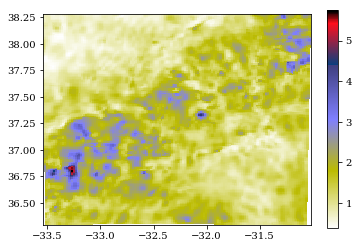

In [56]:
# check result: 2D z-int map
zlev.dz_anyND?
dz = zlev.dz_anyND(topo.T, np.zeros((nx,ny)), hc, np.diff(Cs_w), Nz).T
ekint = (ebcl*dz).sum(axis=0)

fig = plt.figure()
ax = plt.gca()
hpc = ax.pcolormesh(lon, lat, ekint/1e3, cmap="gist_stern_r")
ax.set_aspect(1)
plt.colorbar(hpc, ax=ax)

In [58]:
filname

'luckyto_ebl3D_j485_i513_avg.nc'

In [62]:
zw = zlev.zlev_w(topo.T, np.zeros(topo.T.shape), hc, Cs_w).T
dzb = np.diff(zw, axis=0)

In [64]:
abs(dzb - dz).max()

1.1948391609450937e-08

In [60]:
dir(zlev)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'division',
 'dz_any1D',
 'dz_anyND',
 'get_scoord',
 'np',
 'zlev_rho',
 'zlev_w']